# Factor Analysis on the German data set

Analyze the dataset using Factor Analysis.

In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import FactorAnalyzer

from src.data.data_class import Data
from src.models.preliminaries import Settings
from src.models.dma import DMA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# import data
data_path = os.path.join(Path().cwd().parent, 'data', 'processed')
# df = pd.read_csv(os.path.join(data_path, 'combined_data.csv'), index_col=0)
with open(os.path.join(data_path, 'df_sa.pkl'), 'rb') as f:
    df = pickle.load(f)
selection = pd.read_csv(os.path.join(data_path, 'selected_data.csv'))

## select data

In [40]:
params = Settings() # initialize Settings
# adjust settings
params.use_y = ['CPI']  # use as y
# params.tcodesX = [1, 1, 5, 1, 1, 1, 1, 5, 5, 1, 5, 5, 1]
params.tcodey = 1
params.first_sample_ends = '1995-12-31'
params.restricted_vars = ['intercept', 'CPI']
params.forgetting_method = 2
params.expert_opinion = 2
params.h_fore = 4
params.prior_theta = 1
params.plag = 2
params.hlag = 0
params.miss_treatment = 1
params.intercept = 1

In [41]:
# restricted_vars = ['prod_ind',
#                    'unemp',
#                    'GDP',
#                    'cons_private',
#                    'interest_rate_short',
#                    'interest_rate_long',
#                    'M1']
infl_vars = ['CPI',
             'deflator_GDP',
             'HICP_excl_energy']
labor_market = ['unemp',
                'employment',
                'earnings_hourly']
macro_nrs = ['GDP',
             'cons_private',
             'cons_gov',
             'trade_imp',
             'trade_exp']
investment = ['invest',
              'invest_government',
              'invest_private_no_housing',
              'invest_private_housing',
              #'invest_total',
              'residential_permits']
prod_indices=['prod_ind',
              'retail',
              'prod_constr']
financial1=['dax']
financial2=['interest_rate_short',
            'interest_rate_long']
money=['M1',
       'M3']
infl_exp = ['infl_exp_current_year',
           'infl_exp_next_year',
           #'infl_exp_1_year_ahead',
           'infl_exp_2_year_ahead',
           'infl_exp_5_year_ahead']
infl_predictors = ['PCI_energy_',
                   'HICP_energy',
                   'CPI_house_energy']
supply_ind = ['supply_index_global',
              'supply_index_eu']
confidence = ['business_conf_manufacturing',
              #'business_conf_construct',
              #'business_conf_service',
              'business_conf_retail']
confidence2 = ['cons_conf_tendency',
              'business_situation']
var_groups = {'labor_market': labor_market,
              'macro_nrs': macro_nrs,
              'investment': investment,
              'prod_indices': prod_indices,
              'financial1': financial1,
              'financial2': financial2,
              'money': money,
              'infl_exp': infl_exp,
              'infl_predictors': infl_predictors,
              'supply_ind': supply_ind,
              'confidence': confidence,
              'confidence2': confidence2}
potential_exo = labor_market + macro_nrs + investment + prod_indices + financial1 + financial2 + money + infl_exp + infl_predictors + supply_ind + confidence + confidence2

In [42]:
params.use_x = potential_exo
params.tcodesX = params.get_tcodesX(selection)

In [43]:
data = Data(df, params)
# exclude intercept and CPI from Factpor Analysis
data_CPI_intercept = data.X.loc[:, ['intercept', 'CPI', 'CPI_t-1', 'CPI_t-2']]
data.X = data.X.drop(['intercept', 'CPI', 'CPI_t-1', 'CPI_t-2'], axis=1)

In [44]:
# # transform_data
# for name, values in df.iteritems():
#     if np.where(selection['var code']==name)[0].size:
#         print(f'transform {name}')
#         v_ind = np.where(selection['var code']==name)[0][0]
#         tcode = selection['trans_code'][v_ind]
#         df[name] = Data.transx(values, tcode)
#     else:
#         print(f'drop {name}')
#         df.drop(name, axis=1)

In [45]:
# # lag variables
# for names, values in df.iteritems():
#     lag_1_name = names + '_lag1'
#     lag_2_name = names + '_lag2'
#     df[lag_1_name] = values.shift(1)
#     df[lag_2_name] = values.shift(2)
# print(f'The df now has {len(df.columns)} variables')

## Factor Analysis

In [46]:
# Instantiate factor analysis object
n_factors = 5
fa = FactorAnalyzer(rotation='varimax', n_factors=n_factors)
fa.fit(data.X)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()

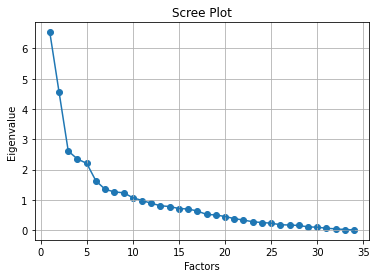

In [47]:
plt.scatter(range(1,data.X.shape[1]+1), ev)
plt.plot(range(1,data.X.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [48]:
# choose the first X factors (formally all with EV > 1?)
fa_loadings = pd.DataFrame(fa.loadings_, columns=range(1,n_factors+1), index=data.X.columns)
fa_loadings

,1,2,3,4,5
unemp,-0.493542,-0.132366,-0.220849,-0.186337,-0.171264
employment,0.329342,0.038120,0.215616,0.177278,0.043724
earnings_hourly,-0.319763,-0.027099,-0.027487,-0.073584,0.084497
GDP,0.087488,0.225027,0.338469,0.824872,0.119396
cons_private,0.029525,-0.018276,0.092480,0.716517,-0.090487
cons_gov,-0.036729,0.059162,0.353616,-0.043223,-0.085307
trade_imp,0.093947,0.426176,0.117721,0.247598,0.448400
trade_exp,0.071630,0.491472,0.010811,0.332260,0.361328
invest,0.158705,0.203997,0.840904,0.322696,0.073984
invest_government,0.254590,0.219162,0.665234,0.485941,0.140741


## DMA with factors

In [49]:
df_factors = pd.DataFrame(fa.transform(data.X.dropna()), index = data.X.dropna().index)
df_factors

,0,1,2,3,4
1992-03-31,-1.954214,-0.671133,1.713170,0.825333,0.010532
1992-06-30,-2.311502,-0.758880,0.055634,-0.172105,-0.303989
1992-09-30,-2.462712,-1.002638,-0.687091,0.060443,0.746405
1992-12-31,-2.458235,-1.113425,0.810002,-0.781752,-0.406643
1993-03-31,-2.673165,-1.094410,-0.123217,-0.948512,1.150798
...,...,...,...,...,...
2020-12-31,0.020260,1.925531,0.437192,-0.805446,0.433042
2021-03-31,0.101655,2.044935,-0.329430,-1.383907,1.370767
2021-06-30,0.735872,1.250376,0.079453,0.004009,-0.370191
2021-09-30,0.762292,-0.094079,-0.655773,-0.334434,0.316848


In [50]:
factor_cols = ['Factor_'+str(i) for i in list(df_factors.columns)]
df_factors.columns = factor_cols

In [51]:
# lag factors
df_factors_with_lag = pd.concat((df_factors, df_factors.shift(1), df_factors.shift(2)), axis=1)
factor_cols_lag1 = [i+'_lag1' for i in factor_cols]
factor_cols_lag2 = [i+'_lag2' for i in factor_cols]
df_factors_with_lag.columns = factor_cols+factor_cols_lag1+factor_cols_lag2

In [52]:
df_comb = pd.concat((data_CPI_intercept, df_factors_with_lag), axis=1)
# df_comb = df_comb.loc['2001-03-31':'2018-12-31', :]
df_comb = df_comb.iloc[2:, :]
data.X = df_comb
data.T = data.T-2
data.N = data.X.shape[1]
data.y_dep = data.y_dep[2:]

In [53]:
dma = DMA(params, data)
dma.run_dma()

100%|██████████| 114/114 [03:45<00:00,  1.98s/it]

DMA finished


In [54]:
dma.forecast_statistics(unit='percent', plot_fe=False, plot_y_fe=True, plot_y_fe_DMS=True)

         MAFE      MSFE      BIAS
DMA  0.819922  0.013699 -0.005892
DMS  0.657794  0.009037 -0.032411


In [57]:
dma.calc_E_size(out='plot')

In [56]:
dma.X

,intercept,CPI,CPI_t-1,CPI_t-2,Factor_0,Factor_1,Factor_2,Factor_3,Factor_4,Factor_0_lag1,Factor_1_lag1,Factor_2_lag1,Factor_3_lag1,Factor_4_lag1,Factor_0_lag2,Factor_1_lag2,Factor_2_lag2,Factor_3_lag2,Factor_4_lag2
1992-09-30,1,0.017066,0.038694,0.053325,-2.462712,-1.002638,-0.687091,0.060443,0.746405,-2.311502,-0.758880,0.055634,-0.172105,-0.303989,-1.954214,-0.671133,1.713170,0.825333,0.010532
1992-12-31,1,0.022676,0.017066,0.038694,-2.458235,-1.113425,0.810002,-0.781752,-0.406643,-2.462712,-1.002638,-0.687091,0.060443,0.746405,-2.311502,-0.758880,0.055634,-0.172105,-0.303989
1993-03-31,1,0.104876,0.022676,0.017066,-2.673165,-1.094410,-0.123217,-0.948512,1.150798,-2.458235,-1.113425,0.810002,-0.781752,-0.406643,-2.462712,-1.002638,-0.687091,0.060443,0.746405
1993-06-30,1,0.026929,0.104876,0.022676,-2.201735,-0.064266,-0.116003,0.129251,0.184679,-2.673165,-1.094410,-0.123217,-0.948512,1.150798,-2.458235,-1.113425,0.810002,-0.781752,-0.406643
1993-09-30,1,0.021613,0.026929,0.104876,-1.984462,0.385335,0.292233,-0.049718,0.062571,-2.201735,-0.064266,-0.116003,0.129251,0.184679,-2.673165,-1.094410,-0.123217,-0.948512,1.150798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,1,-0.010073,-0.023971,0.034673,0.020260,1.925531,0.437192,-0.805446,0.433042,0.308289,1.464910,-0.457219,5.641957,-1.086001,-0.348249,0.584099,-1.973304,-6.321717,-1.803933
2021-03-31,1,0.067885,-0.010073,-0.023971,0.101655,2.044935,-0.329430,-1.383907,1.370767,0.020260,1.925531,0.437192,-0.805446,0.433042,0.308289,1.464910,-0.457219,5.641957,-1.086001
2021-06-30,1,0.060145,0.067885,-0.010073,0.735872,1.250376,0.079453,0.004009,-0.370191,0.101655,2.044935,-0.329430,-1.383907,1.370767,0.020260,1.925531,0.437192,-0.805446,0.433042
2021-09-30,1,0.042699,0.060145,0.067885,0.762292,-0.094079,-0.655773,-0.334434,0.316848,0.735872,1.250376,0.079453,0.004009,-0.370191,0.101655,2.044935,-0.329430,-1.383907,1.370767
